# Задача 6

---


Анализ планет в двойных звёздных системах.

Сравнение планет в двойных звёздных системах с обычными планетами.


---



Как мы знаем из анализа проведённого в 5 задаче, в датасете есть категориальный признак *TypeFlag*, который имеет несколько значений:


*   0 = Планета из обычной системы;
*   1 = планета из двойной звёздной системы (орбита P-типа);
*   2 = планета из двойной звёздной системы (орбита S-типа);
*   3 = планета-сирота (без звезды)


Чтобы понять, что такое орбита Р-типа и орбита S-типа надо взглянуть на рисунок 6.1

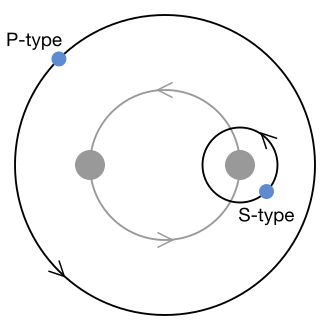

Рисунок 6.1 Разница между орбитами P-типа и S-типа

Попытаемся для начала визуально просмотреть разницу между планетами из бинарных систем и обычными планетами. Для этого ввёдем новый признак *Binary*, а также более мелкие признаки *Binary_S* и *Binary_P* для будущего анализа. Также удалим планеты без звёзд для удобства.

Используем часть кода из 5 задачи.


In [ ]:
import numpy as np # библиотека для эффективной работы с данными
import pandas as pd # библиотека для работы с наборами данных
import matplotlib.pyplot as plt # библиотека для визуализации
import seaborn as sns # еще одна библиотека для построения графиков

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt

data = pd.read_csv('oec.csv')
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3584 entries, 0 to 3583
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PlanetIdentifier      3584 non-null   object 
 1   TypeFlag              3584 non-null   int64  
 2   PlanetaryMassJpt      1313 non-null   float64
 3   RadiusJpt             2774 non-null   float64
 4   PeriodDays            3485 non-null   float64
 5   SemiMajorAxisAU       1406 non-null   float64
 6   Eccentricity          1108 non-null   float64
 7   PeriastronDeg         328 non-null    float64
 8   LongitudeDeg          43 non-null     float64
 9   AscendingNodeDeg      46 non-null     float64
 10  InclinationDeg        665 non-null    float64
 11  SurfaceTempK          741 non-null    float64
 12  AgeGyr                2 non-null      float64
 13  DiscoveryMethod       3521 non-null   object 
 14  DiscoveryYear         3574 non-null   float64
 15  LastUpdated          

Вспомним какие признаки имеют большое количество пустых значений

In [ ]:
null_count = data.isnull().sum() # столбец и количество пропусков в нём
# выбор столбцов с количеством пустых значений больше, чем n
n = 2900
columns_to_drop = null_count[null_count > n].index
# удаление выбранных столбцов
data = data.drop(columns_to_drop, axis=1)

# Обработка *BinaryFlag*

In [ ]:
data = data[data.TypeFlag < 3]
data['Binary'] = (data['TypeFlag'] > 0).astype(int)
data['Binary_S'] = (data['TypeFlag'] == 2).astype(int)
data['Binary_P'] = (data['TypeFlag'] == 1).astype(int)
print('Binary', len(data[data.Binary == 1]))
print('Binary_P', len(data[data.Binary_P == 1]))
print('Binary_S', len(data[data.Binary_S == 1]))


Binary 185
Binary_P 29
Binary_S 156


<ipython-input-3-a632887f0a5a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Binary'] = (data['TypeFlag'] > 0).astype(int)
<ipython-input-3-a632887f0a5a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Binary_S'] = (data['TypeFlag'] == 2).astype(int)
<ipython-input-3-a632887f0a5a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

Обработаем пустые значения с помощью линейной регрессии, размотрим таблицу корреляций.

In [ ]:
from pandas.core import resample

features =     ['SurfaceTempK', 'RadiusJpt', 'PeriodDays','PlanetaryMassJpt', 'Binary', 'Binary_P', 'Binary_S']
all_features = ['PlanetIdentifier', 'SurfaceTempK', 'RadiusJpt', 'PeriodDays','Eccentricity', 'PlanetaryMassJpt', 'Binary_P', 'Binary_S']


def count_nulls_sorted(features): # функция возращающая отсортированный столбец и количество пропусков в нём
  null_count = data[features].isnull().sum() # столбец и количество пропусков в нём
  sorted_cols = null_count.sort_values(ascending=False).index.tolist()
  data_sorted = data[sorted_cols]
  null_count_sorted = null_count[sorted_cols].to_frame(name='null_count')
  return null_count_sorted

print(count_nulls_sorted(features))

                  null_count
SurfaceTempK            2841
PlanetaryMassJpt        2271
RadiusJpt                808
PeriodDays                96
Binary                     0
Binary_P                   0
Binary_S                   0


<ipython-input-5-d866edeec128>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data_sel.corr(), xticklabels=data_sel.corr().columns, yticklabels=data_sel.corr().columns, cmap='RdYlGn', center=0, annot=True)


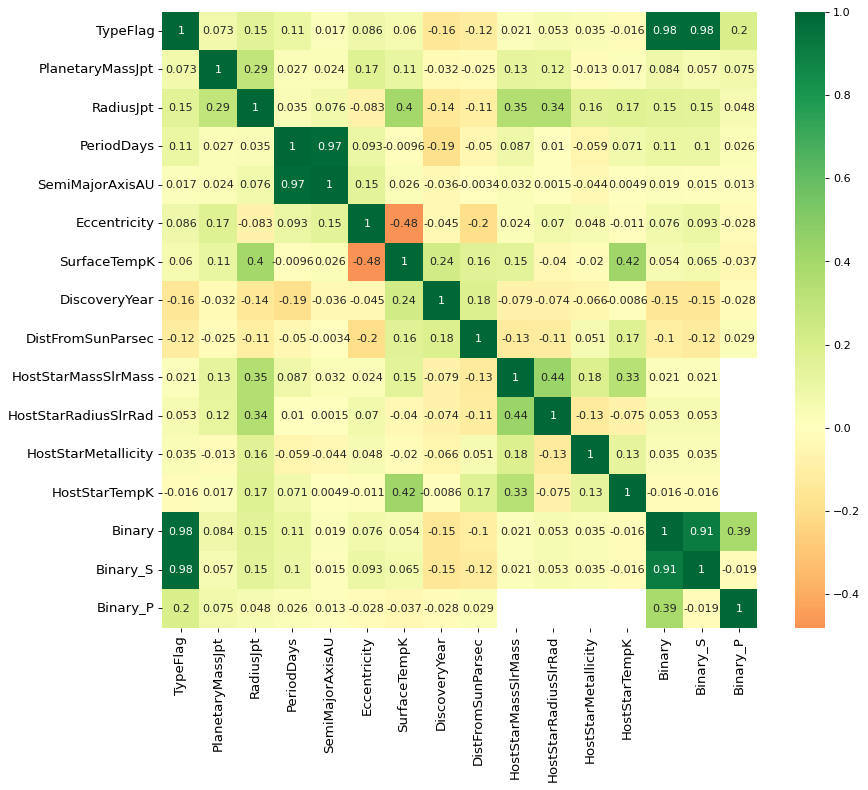

In [ ]:
data_sel = data
# Plot
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(data_sel.corr(), xticklabels=data_sel.corr().columns, yticklabels=data_sel.corr().columns, cmap='RdYlGn', center=0, annot=True)

# Decorations
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Для переменной *SurfaceTempK* есть корреляции, обработаем её, *PlanetaryMass* заменим на средние значения.

Возьмём значения, которые не имеют много пропусков.

In [ ]:
# выбор столбцов с количеством пустых значений больше, чем n
n = 500
columns_to_regress = null_count[null_count < n].index


In [ ]:
# разделение датасета на признаки и целевую переменную
data_copy1 = data.copy()

data_sel = data.dropna(subset=['RadiusJpt', 'HostStarTempK', 'SurfaceTempK'])

data_copy = data.copy()


data.dropna(subset=['RadiusJpt', 'HostStarTempK'], inplace=True)
# выбор двух признаков
X = data_sel[['RadiusJpt', 'HostStarTempK']]
y = data_sel['SurfaceTempK']
# заполнение пустых значений с помощью линейной регрессии
from sklearn.linear_model import LinearRegression
print(len(X))
regressor = LinearRegression()
regressor.fit(X, y)

data['SurfaceTempK'].fillna(pd.Series(regressor.predict(data[X.columns])), inplace=True)
# data['PlanetaryMassJpt'].fillna(value=np.mean(data['PlanetaryMassJpt']),inplace=True)
data.dropna(subset='PlanetaryMassJpt', inplace=True)

len(data)

352


505

In [ ]:
print(count_nulls_sorted(features))

                  null_count
SurfaceTempK              45
PeriodDays                11
RadiusJpt                  0
PlanetaryMassJpt           0
Binary                     0
Binary_P                   0
Binary_S                   0


In [ ]:
print('Binary_P', len(data[data.Binary_P == 1]))


Binary_P 0


# ВЫБОРКА ЗНАЧЕНИЙ

In [ ]:
# загрузка данных
df = data

# создание нового dataframe с данными для выбранных планет
new_df = df
# масштабирование данных
scaler = StandardScaler()
features = ['SurfaceTempK', 'RadiusJpt', 'PeriodDays','PlanetaryMassJpt', 'Binary', 'Binary_P', 'Binary_S']

data_sel = data[features]
data_sel = data_sel[data_sel.PlanetaryMassJpt < 3]
data_sel = data_sel[data_sel.SurfaceTempK < 5000]
data_sel = data_sel[data_sel.PeriodDays < 200]


data_sel.dropna(inplace=True)


#Нормализация параметров.

In [ ]:

scaled_features = scaler.fit_transform(data_sel)
scaled_df = pd.DataFrame(scaled_features, columns=features)

#удаляем значения
binary = data_sel.Binary
binary_p = data_sel.Binary_P
binary_s = data_sel.Binary_S

scaled_df = scaled_df.drop('Binary', axis=1)
scaled_df = scaled_df.drop('Binary_P', axis=1)
scaled_df = scaled_df.drop('Binary_S', axis=1)
len(scaled_df)

397

In [ ]:
pca = PCA()
pca.fit(scaled_df)
X_pca = pca.transform(scaled_df)

for i, component in enumerate(pca.components_):
    print("{} component: {}% of initial variance".format(i + 1,
          round(100 * pca.explained_variance_ratio_[i], 2)))
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,scaled_df.columns)))

1 component: 54.86% of initial variance
-0.536 x SurfaceTempK + -0.571 x RadiusJpt + 0.358 x PeriodDays + -0.508 x PlanetaryMassJpt
2 component: 21.86% of initial variance
-0.119 x SurfaceTempK + 0.275 x RadiusJpt + 0.857 x PeriodDays + 0.420 x PlanetaryMassJpt
3 component: 14.28% of initial variance
0.707 x SurfaceTempK + 0.097 x RadiusJpt + 0.361 x PeriodDays + -0.600 x PlanetaryMassJpt
4 component: 9.0% of initial variance
-0.446 x SurfaceTempK + 0.767 x RadiusJpt + -0.086 x PeriodDays + -0.453 x PlanetaryMassJpt


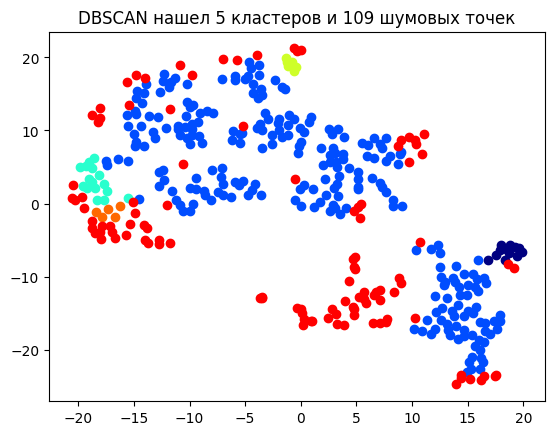

In [ ]:
#снизим размерность данных при помощи метода главных компонент
pca = PCA(n_components=4).fit(data_sel)
pdata = pca.transform(data_sel)

#нормализуем данные
scaler = StandardScaler()
data2 = scaler.fit_transform(pdata)

#используем dbscan для обнаружения кластеров
dbscan = DBSCAN()
dbscan.fit(data2)
labels = dbscan.labels_

tsne = TSNE()
pca_2d = tsne.fit_transform(data2)

#визуализируем кластеры
for label in set(labels):
    if label == -1:
        plt.scatter(pca_2d[labels == label, 0], pca_2d[labels == label, 1], color='red')
    else:
        plt.scatter(pca_2d[labels == label, 0], pca_2d[labels == label, 1], color=plt.cm.jet(label / np.max(labels + 1)))
plt.title('DBSCAN нашел {} кластеров и {} шумовых точек'.format(len(set(labels)) - (1 if -1 in labels else 0), np.sum(labels == -1)))
plt.show()

In [ ]:
unique_labels = np.unique(labels)
for label in unique_labels:
    if label == -1:
        print("Шум: ", np.sum(labels == -1))
    else:
        print("Количество элементов в кластере", label, ":", np.sum(labels == label))

Шум:  109
Количество элементов в кластере 0 : 12
Количество элементов в кластере 1 : 249
Количество элементов в кластере 2 : 16
Количество элементов в кластере 3 : 6
Количество элементов в кластере 4 : 5


In [ ]:
centroids = []
unique_labels = np.unique(labels)

for label in unique_labels:
    if label == -1:
        continue
    else:
        indices = np.where(labels == label)[0]
        centroid_index = indices[0]
        centroid = data2[centroid_index]
        centroids.append(centroid)

original = scaler.inverse_transform(centroids)
original_pca = pca.inverse_transform(original)
centr = pd.DataFrame(original_pca, columns=data_sel.columns)

print(centroids)

centr

[array([-1.86687971, -1.22890289, -0.58320824, -0.69616511]), array([ 0.5313553 , -0.16283209, -0.36466588,  0.45123348]), array([ 1.54910798,  0.18828382,  1.28288986, -0.98622165]), array([ 0.50127317, -0.15634671, -0.32538709,  2.08430204]), array([ 0.02187863, -0.46038325,  2.24914949, -1.37702748])]


,SurfaceTempK,RadiusJpt,PeriodDays,PlanetaryMassJpt,Binary,Binary_P,Binary_S
0,363.105309,0.110954,0.176923,-0.016208,-0.083380,0.0,-0.083380
1,1400.000020,1.158047,3.372604,0.625337,0.119979,0.0,0.119979
2,1840.000003,1.452990,2.790825,2.184022,0.019047,0.0,0.019047
3,1386.999883,1.638985,3.713285,0.443151,0.304630,0.0,0.304630
4,1179.699992,1.178420,1.337137,2.476359,-0.050390,0.0,-0.050390


In [ ]:
data.describe()

,TypeFlag,PlanetaryMassJpt,RadiusJpt,PeriodDays,SemiMajorAxisAU,Eccentricity,SurfaceTempK,DiscoveryYear,DistFromSunParsec,HostStarMassSlrMass,HostStarRadiusSlrRad,HostStarMetallicity,HostStarTempK,Binary,Binary_S,Binary_P
count,505.000000,505.000000,505.000000,494.000000,451.000000,320.000000,460.000000,499.000000,427.000000,502.000000,493.000000,435.000000,505.000000,505.000000,505.000000,505.0
mean,0.126733,1.553698,0.991152,1101.268491,2.279375,0.073000,1216.143077,2011.326653,461.308253,1.058813,1.224147,0.062159,5748.015842,0.063366,0.063366,0.0
std,0.487725,3.309758,0.551983,10004.200265,31.596848,0.138729,612.821839,13.595989,420.206301,0.293099,0.572346,0.197628,1612.311634,0.243862,0.243862,0.0
min,0.000000,0.000008,0.016438,0.176891,0.004800,0.000000,198.600000,1781.000000,6.546000,0.080000,0.089000,-0.840000,2205.000000,0.000000,0.000000,0.0
25%,0.000000,0.101000,0.565000,2.792484,0.038537,0.000000,895.783933,2010.500000,196.500000,0.922250,0.925000,-0.030000,5400.000000,0.000000,0.000000,0.0
50%,0.000000,0.670000,1.099000,3.950906,0.048530,0.010900,1114.583060,2012.000000,330.000000,1.060000,1.107000,0.070000,5778.000000,0.000000,0.000000,0.0
75%,0.000000,1.450000,1.330000,9.268959,0.075100,0.080000,1490.470369,2015.000000,602.000000,1.215250,1.475000,0.200000,6100.000000,0.000000,0.000000,0.0
max,2.000000,30.000000,6.000000,166510.000000,662.000000,0.933690,7112.000000,2017.000000,3200.000000,2.820000,6.300000,0.440000,27730.000000,1.000000,1.000000,0.0


#Класстеризация с помощью KMeans

Определим необходимое количество класстеров.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

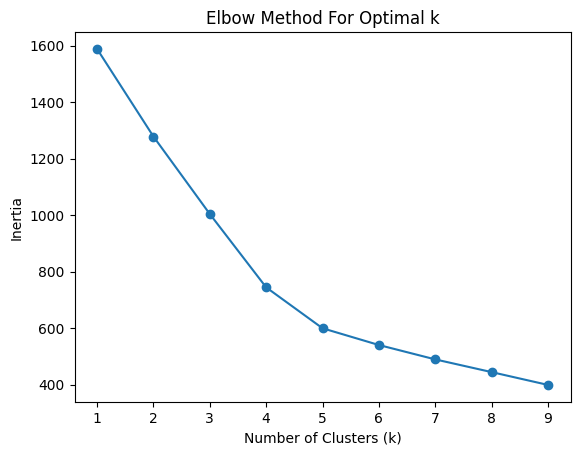

In [ ]:
from sklearn.cluster import KMeans

# Определите диапазон числа кластеров, которые вы хотите проверить
num_clusters = range(1, 10)

# Инициализируйте список для хранения значений инерции
inertias = []

# Вычисляем инерцию для каждого заданного количества кластеров
for k in num_clusters:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data2)
    inertias.append(kmeans.inertia_)

# Построить график метода локтя
plt.plot(num_clusters, inertias, '-o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

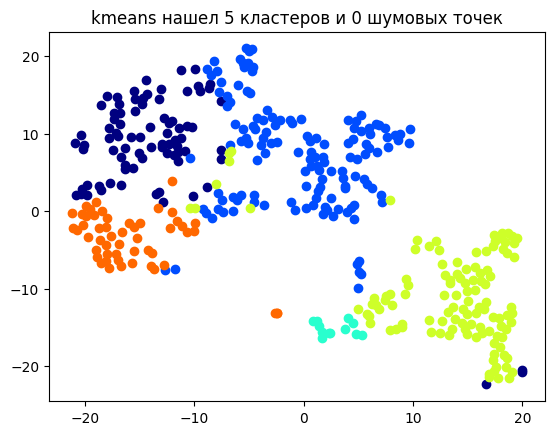

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, n_init = 'auto', random_state = 157)
kmeans.fit(data2)
labels = kmeans.labels_

tsne = TSNE()
pca_2d = tsne.fit_transform(data2)

for label in set(labels):
    if label == -1:
        plt.scatter(pca_2d[labels == label, 0], pca_2d[labels == label, 1], color='blue')
    else:
        plt.scatter(pca_2d[labels == label, 0], pca_2d[labels == label, 1], color=plt.cm.jet(label / np.max(labels + 1)))

plt.title('kmeans нашел {} кластеров и {} шумовых точек'.format(len(set(labels)) - (1 if -1 in labels else 0), np.sum(labels == -1)))
plt.show()

In [ ]:
centroids = kmeans.cluster_centers_
print("Центры полученных кластеров:")
for i in range(len(centroids)):
    print(f"Кластер {i}: {centroids[i]}")

labels = kmeans.labels_
unique_labels = np.unique(labels)
for label in unique_labels:
    if label == -1:
        print("Шум: ", np.sum(labels == -1))
    else:
        print("Количество элементов в кластере", label, ":", np.sum(labels == label))

cluster_predictions = kmeans.predict(data2)

original = scaler.inverse_transform(kmeans.cluster_centers_)
original_pca = pca.inverse_transform(original)
centr = pd.DataFrame(original_pca, columns=data_sel.columns)

print(centr)
print(centroids)


Центры полученных кластеров:
Кластер 0: [ 1.33829611  0.11047773  0.01751363 -0.13435203]
Кластер 1: [-0.11246121 -0.32845564  0.00404625  0.95898809]
Кластер 2: [-1.06898437  4.61302979  0.20153489  0.36191581]
Кластер 3: [-0.65885611 -0.09196794 -0.89606214 -0.67234392]
Кластер 4: [-0.11248637 -0.17633176  1.89696768 -0.89286447]
Количество элементов в кластере 0 : 82
Количество элементов в кластере 1 : 136
Количество элементов в кластере 2 : 12
Количество элементов в кластере 3 : 115
Количество элементов в кластере 4 : 52
   SurfaceTempK  RadiusJpt  PeriodDays  PlanetaryMassJpt    Binary  Binary_P  \
0   1748.859605   1.309443    2.812210          1.171777  0.084566       0.0   
1   1121.679226   1.226470    4.825794          0.635224  0.165967       0.0   
2    709.828781   0.697461  106.378622          0.333283  0.071128       0.0   
3    885.594714   0.347228   13.280691          0.061637 -0.052310       0.0   
4   1121.715928   1.181151    7.744363          2.128275 -0.006610   

In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px

df = data_sel

tsne = TSNE(n_components=3, random_state=0)
projections = tsne.fit_transform(data_sel)

fig = px.scatter_3d(
    projections, x=0, y=1, z=2,
    color=df.species, labels={'color': 'species'}
)
fig.update_traces(marker_size=8)
fig.show()


AttributeError: ignored

# Графики

In [ ]:
# создаем график

plt.scatter(data_sel['RadiusJpt'], data_sel['PlanetaryMassJpt'], c=binary, cmap='viridis')
plt.xlabel('RadiusJpt')
plt.ylabel('PlanetaryMassJpt')
plt.title('Фиолетовый - обычные планеты')
plt.show()
# построение scatter plot

# создаем график
plt.scatter(data_sel['RadiusJpt'], data_sel['SurfaceTempK'], c=binary, cmap='viridis')
plt.xlabel('RadiusJpt')
plt.ylabel('SurfaceTempK')
plt.title('')
plt.show()
# построение scatter plot

# создаем график
plt.scatter(data_sel['SurfaceTempK'], data_sel['PeriodDays'], c=binary, cmap='viridis')
plt.xlabel('SurfaceTempK')
plt.ylabel('PeriodDays')
plt.title('')
plt.show()
# построение scatter plot

#Проанализируем планеты различных типов

In [ ]:
data = data_copy
data = data[data.PlanetaryMassJpt < 3]
data = data[data.SurfaceTempK < 5000]
data = data[data.PeriodDays < 1000]

In [ ]:
data[data.Binary == 0][all_features].describe()

In [ ]:
data[data.Binary_S == 1][all_features].describe()

Бинарные планеты S-типа имеют в среднем большую температуру, ближе находятся к звезде, и имеют большую массу.

In [ ]:
data = data_copy1
# data = data[data.PlanetaryMassJpt < 3]
# data = data[data.SurfaceTempK < 5000]
# data = data[data.PeriodDays < 100000]

In [ ]:
data[data.Binary_P == 1][all_features].describe()

Рассмотрим планеты солнечной системы

In [ ]:
# создаем маску для отбора нужных строк
mask = data['ListsPlanetIsOn'].str.contains('Solar System')

# отбираем нужные строки
solar_system = data[mask]

solar_system

In [ ]:
data = data_copy
earth_plt1 = data[(data.SurfaceTempK > 170)&(data.SurfaceTempK < 350)&(data.Binary == 1)]


earth_plt1

Из этих планет можно выделить Proxima Centauri b, которая имеет температуру -40, и массу, похожую на массу земли, можно предположить, что там может теоретически быть жизнь, хоть и год на такой планете идёт всего 11 дней.

In [ ]:
earth_plt2 = data[(((data.RadiusJpt > 0.0025)&(data.RadiusJpt < 0.1))&
                  (data.PlanetaryMassJpt > 0.0015)&(data.PlanetaryMassJpt < 0.03))&(data.Binary == 1)][all_features]
earth_plt2


Эта планета скорее всего тоже не представляет интереса, так как скорее всего имеет гигантскую температуру.